# GAN para generar imágenes de Fashion MNIST

# Autor: Germán García Estévez

Se implementa una Red Generativa Antagónica (GAN) para generar imágenes de prendas y accesorios utilizando el dataset **Fashion MNIST**.

Se incluye la definición de los modelos (generador y discriminador), el proceso de entrenamiento y la generación de imágenes de ejemplo.


In [1]:
# Importar librerías necesarias
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
import numpy as np
import matplotlib.pyplot as plt
import os

## Cargar y preprocesar el dataset MNIST

In [2]:
# Cargar el dataset Fashion MNIST
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizar las imágenes al rango [-1, 1] (para que se ajusten a la salida de la función tanh en el generador)
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # Escalar a [-1, 1]
train_images = np.expand_dims(train_images, axis=-1)  # Agregar dimensión del canal

BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 256

# Crear el dataset de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

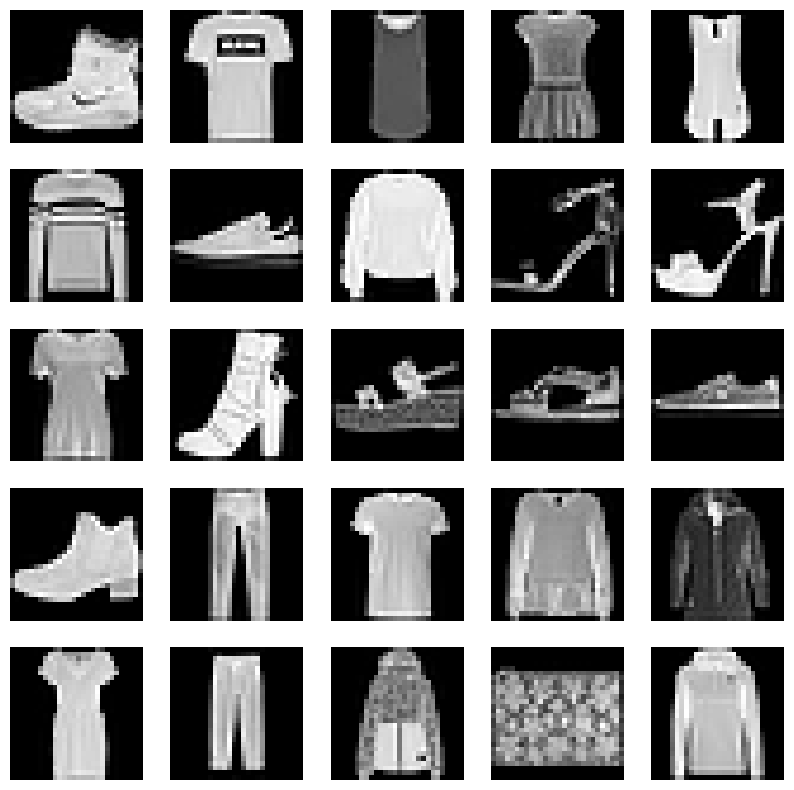

In [3]:
# Visualizar algunas imágenes de ejemplo
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

## Definición del generador

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


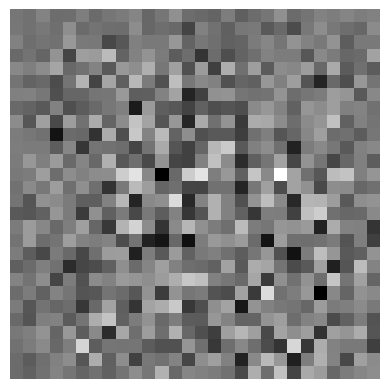

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    # Capa densa para transformar el vector de entrada en una forma adecuada
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape a 7x7x256
    model.add(layers.Reshape((7, 7, 256)))
    # Upsampling a 14x14x128
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Upsampling a 14x14x64
    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Capa de salida para obtener 28x28x1
    model.add(layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh'))

    return model

# Instanciar el generador
generator = make_generator_model()
# Probar la generación de una imagen
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

## Definición del discriminador

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # Primera capa convolucional
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # Segunda capa convolucional
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # Aplanar y capa de salida
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Instanciar el discriminador
discriminator = make_discriminator_model()
# Probar el discriminador con una imagen real
decision = discriminator(train_images[0:1])
print("Salida del discriminador:", decision)

Salida del discriminador: tf.Tensor([[0.11653015]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Función de pérdida y optimizadores

In [6]:
# Función de pérdida para ambas redes
cross_entropy = losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # Etiqueta real = 1, fake = 0
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # El generador quiere que el discriminador clasifique las imágenes generadas como reales (etiqueta 1)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

## Entrenamiento

In [7]:
# Número de epochs y tamaño del vector de ruido
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Semilla para visualizar el progreso durante el entrenamiento
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Iterar por cada batch en el dataset
        for batch_index, image_batch in enumerate(dataset):
            g_loss, d_loss = train_step(image_batch)
            print(f"  Epoch {epoch+1} - Batch {batch_index+1}: Generator loss = {g_loss:.4f}, Discriminator loss = {d_loss:.4f}")

        # Generar y guardar/mostrar imágenes cada 2 epochs
        if (epoch + 1) % 2 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

## Generación de imágenes durante el entrenamiento

In [8]:
def generate_and_save_images(model, epoch, test_input):
    # Generar imágenes
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}', fontsize=16)
    plt.show()

## Ejecución del entrenamiento

Epoch 1/50
  Epoch 1 - Batch 1: Generator loss = 0.6652, Discriminator loss = 1.3779
  Epoch 1 - Batch 2: Generator loss = 0.6438, Discriminator loss = 1.3615
  Epoch 1 - Batch 3: Generator loss = 0.6268, Discriminator loss = 1.3538
  Epoch 1 - Batch 4: Generator loss = 0.6093, Discriminator loss = 1.3346
  Epoch 1 - Batch 5: Generator loss = 0.5997, Discriminator loss = 1.3146
  Epoch 1 - Batch 6: Generator loss = 0.5897, Discriminator loss = 1.3017
  Epoch 1 - Batch 7: Generator loss = 0.5866, Discriminator loss = 1.2788
  Epoch 1 - Batch 8: Generator loss = 0.5863, Discriminator loss = 1.2560
  Epoch 1 - Batch 9: Generator loss = 0.5839, Discriminator loss = 1.2305
  Epoch 1 - Batch 10: Generator loss = 0.5810, Discriminator loss = 1.2183
  Epoch 1 - Batch 11: Generator loss = 0.5813, Discriminator loss = 1.1989
  Epoch 1 - Batch 12: Generator loss = 0.5792, Discriminator loss = 1.1781
  Epoch 1 - Batch 13: Generator loss = 0.5702, Discriminator loss = 1.1732
  Epoch 1 - Batch 14: G

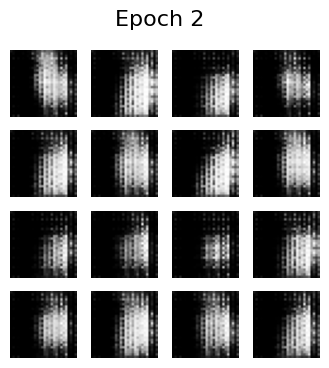

Epoch 3/50
  Epoch 3 - Batch 1: Generator loss = 0.9127, Discriminator loss = 1.2915
  Epoch 3 - Batch 2: Generator loss = 0.9097, Discriminator loss = 1.2737
  Epoch 3 - Batch 3: Generator loss = 0.9129, Discriminator loss = 1.3461
  Epoch 3 - Batch 4: Generator loss = 0.8930, Discriminator loss = 1.2688
  Epoch 3 - Batch 5: Generator loss = 0.9029, Discriminator loss = 1.2979
  Epoch 3 - Batch 6: Generator loss = 0.8938, Discriminator loss = 1.2927
  Epoch 3 - Batch 7: Generator loss = 0.8876, Discriminator loss = 1.3114
  Epoch 3 - Batch 8: Generator loss = 0.8625, Discriminator loss = 1.2887
  Epoch 3 - Batch 9: Generator loss = 0.8641, Discriminator loss = 1.2639
  Epoch 3 - Batch 10: Generator loss = 0.8584, Discriminator loss = 1.2524
  Epoch 3 - Batch 11: Generator loss = 0.8773, Discriminator loss = 1.2684
  Epoch 3 - Batch 12: Generator loss = 0.8671, Discriminator loss = 1.2724
  Epoch 3 - Batch 13: Generator loss = 0.8675, Discriminator loss = 1.3345
  Epoch 3 - Batch 14: G

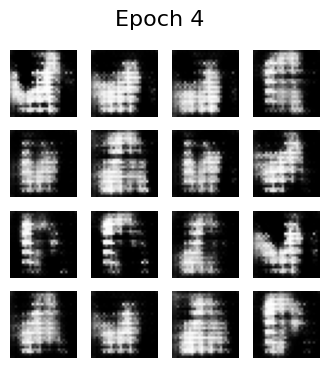

Epoch 5/50
  Epoch 5 - Batch 1: Generator loss = 0.8846, Discriminator loss = 1.2762
  Epoch 5 - Batch 2: Generator loss = 0.8500, Discriminator loss = 1.2815
  Epoch 5 - Batch 3: Generator loss = 0.8247, Discriminator loss = 1.3294
  Epoch 5 - Batch 4: Generator loss = 0.8124, Discriminator loss = 1.2742
  Epoch 5 - Batch 5: Generator loss = 0.8257, Discriminator loss = 1.2556
  Epoch 5 - Batch 6: Generator loss = 0.8184, Discriminator loss = 1.2644
  Epoch 5 - Batch 7: Generator loss = 0.8010, Discriminator loss = 1.3267
  Epoch 5 - Batch 8: Generator loss = 0.8236, Discriminator loss = 1.2470
  Epoch 5 - Batch 9: Generator loss = 0.7798, Discriminator loss = 1.2996
  Epoch 5 - Batch 10: Generator loss = 0.8007, Discriminator loss = 1.2665
  Epoch 5 - Batch 11: Generator loss = 0.8095, Discriminator loss = 1.2401
  Epoch 5 - Batch 12: Generator loss = 0.7843, Discriminator loss = 1.3094
  Epoch 5 - Batch 13: Generator loss = 0.8202, Discriminator loss = 1.2659
  Epoch 5 - Batch 14: G

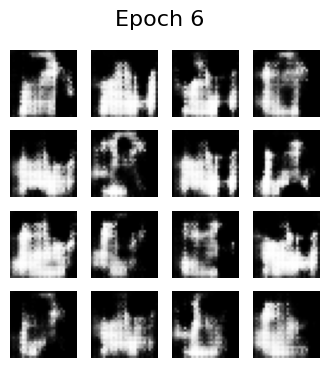

Epoch 7/50
  Epoch 7 - Batch 1: Generator loss = 0.7778, Discriminator loss = 1.2465
  Epoch 7 - Batch 2: Generator loss = 0.8095, Discriminator loss = 1.2605
  Epoch 7 - Batch 3: Generator loss = 0.8143, Discriminator loss = 1.2029
  Epoch 7 - Batch 4: Generator loss = 0.8356, Discriminator loss = 1.1684
  Epoch 7 - Batch 5: Generator loss = 0.8282, Discriminator loss = 1.1891
  Epoch 7 - Batch 6: Generator loss = 0.8358, Discriminator loss = 1.1454
  Epoch 7 - Batch 7: Generator loss = 0.8309, Discriminator loss = 1.1134
  Epoch 7 - Batch 8: Generator loss = 0.8380, Discriminator loss = 1.1372
  Epoch 7 - Batch 9: Generator loss = 0.8520, Discriminator loss = 1.1108
  Epoch 7 - Batch 10: Generator loss = 0.8714, Discriminator loss = 1.1072
  Epoch 7 - Batch 11: Generator loss = 0.8643, Discriminator loss = 1.1268
  Epoch 7 - Batch 12: Generator loss = 0.8929, Discriminator loss = 1.0807
  Epoch 7 - Batch 13: Generator loss = 0.8919, Discriminator loss = 1.0744
  Epoch 7 - Batch 14: G

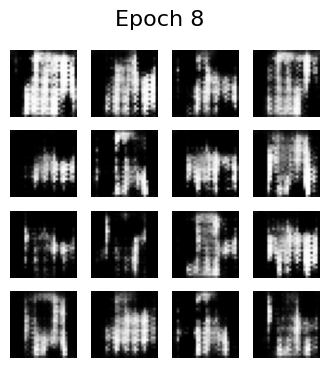

Epoch 9/50
  Epoch 9 - Batch 1: Generator loss = 0.8896, Discriminator loss = 1.1997
  Epoch 9 - Batch 2: Generator loss = 0.9396, Discriminator loss = 1.0856
  Epoch 9 - Batch 3: Generator loss = 0.9248, Discriminator loss = 1.1195
  Epoch 9 - Batch 4: Generator loss = 0.9264, Discriminator loss = 1.2127
  Epoch 9 - Batch 5: Generator loss = 0.9151, Discriminator loss = 1.1477
  Epoch 9 - Batch 6: Generator loss = 0.9135, Discriminator loss = 1.2175
  Epoch 9 - Batch 7: Generator loss = 0.9271, Discriminator loss = 1.1711
  Epoch 9 - Batch 8: Generator loss = 0.8970, Discriminator loss = 1.2435
  Epoch 9 - Batch 9: Generator loss = 0.9240, Discriminator loss = 1.2410
  Epoch 9 - Batch 10: Generator loss = 0.8910, Discriminator loss = 1.2275
  Epoch 9 - Batch 11: Generator loss = 0.8680, Discriminator loss = 1.3195
  Epoch 9 - Batch 12: Generator loss = 0.8274, Discriminator loss = 1.2719
  Epoch 9 - Batch 13: Generator loss = 0.8057, Discriminator loss = 1.2923
  Epoch 9 - Batch 14: G

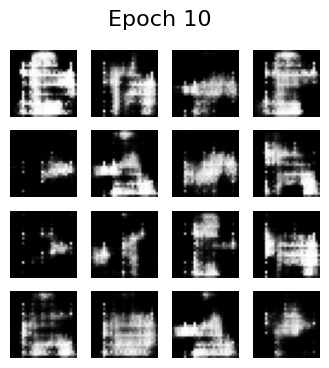

Epoch 11/50
  Epoch 11 - Batch 1: Generator loss = 0.7895, Discriminator loss = 1.3802
  Epoch 11 - Batch 2: Generator loss = 0.7697, Discriminator loss = 1.4473
  Epoch 11 - Batch 3: Generator loss = 0.7832, Discriminator loss = 1.3651
  Epoch 11 - Batch 4: Generator loss = 0.7824, Discriminator loss = 1.3641
  Epoch 11 - Batch 5: Generator loss = 0.7756, Discriminator loss = 1.4239
  Epoch 11 - Batch 6: Generator loss = 0.7812, Discriminator loss = 1.3572
  Epoch 11 - Batch 7: Generator loss = 0.7756, Discriminator loss = 1.4123
  Epoch 11 - Batch 8: Generator loss = 0.7908, Discriminator loss = 1.3672
  Epoch 11 - Batch 9: Generator loss = 0.8272, Discriminator loss = 1.3118
  Epoch 11 - Batch 10: Generator loss = 0.7990, Discriminator loss = 1.3268
  Epoch 11 - Batch 11: Generator loss = 0.7742, Discriminator loss = 1.3756
  Epoch 11 - Batch 12: Generator loss = 0.7777, Discriminator loss = 1.3722
  Epoch 11 - Batch 13: Generator loss = 0.7864, Discriminator loss = 1.3262
  Epoch 1

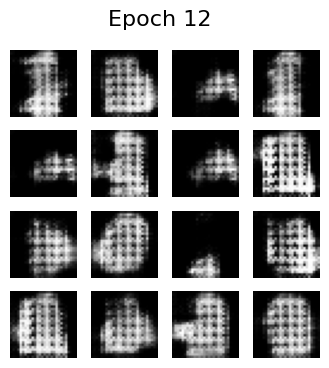

Epoch 13/50
  Epoch 13 - Batch 1: Generator loss = 0.8759, Discriminator loss = 1.2081
  Epoch 13 - Batch 2: Generator loss = 0.9261, Discriminator loss = 1.1837
  Epoch 13 - Batch 3: Generator loss = 0.9058, Discriminator loss = 1.1705
  Epoch 13 - Batch 4: Generator loss = 0.9079, Discriminator loss = 1.1776
  Epoch 13 - Batch 5: Generator loss = 0.9099, Discriminator loss = 1.1404
  Epoch 13 - Batch 6: Generator loss = 0.9242, Discriminator loss = 1.1943
  Epoch 13 - Batch 7: Generator loss = 0.9015, Discriminator loss = 1.1515
  Epoch 13 - Batch 8: Generator loss = 0.8866, Discriminator loss = 1.1611
  Epoch 13 - Batch 9: Generator loss = 0.8770, Discriminator loss = 1.1423
  Epoch 13 - Batch 10: Generator loss = 0.8975, Discriminator loss = 1.1270
  Epoch 13 - Batch 11: Generator loss = 0.8943, Discriminator loss = 1.1729
  Epoch 13 - Batch 12: Generator loss = 0.9031, Discriminator loss = 1.1608
  Epoch 13 - Batch 13: Generator loss = 0.8967, Discriminator loss = 1.1547
  Epoch 1

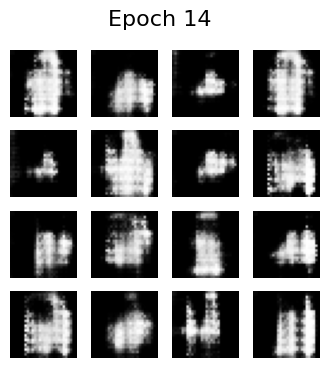

Epoch 15/50
  Epoch 15 - Batch 1: Generator loss = 1.2462, Discriminator loss = 1.0210
  Epoch 15 - Batch 2: Generator loss = 1.2345, Discriminator loss = 1.0266
  Epoch 15 - Batch 3: Generator loss = 1.2906, Discriminator loss = 0.9473
  Epoch 15 - Batch 4: Generator loss = 1.2171, Discriminator loss = 1.0426
  Epoch 15 - Batch 5: Generator loss = 1.1780, Discriminator loss = 1.1632
  Epoch 15 - Batch 6: Generator loss = 1.2368, Discriminator loss = 1.0660
  Epoch 15 - Batch 7: Generator loss = 1.2355, Discriminator loss = 1.0978
  Epoch 15 - Batch 8: Generator loss = 1.1621, Discriminator loss = 1.0994
  Epoch 15 - Batch 9: Generator loss = 1.2161, Discriminator loss = 1.1711
  Epoch 15 - Batch 10: Generator loss = 1.1863, Discriminator loss = 1.0433
  Epoch 15 - Batch 11: Generator loss = 1.1698, Discriminator loss = 1.1916
  Epoch 15 - Batch 12: Generator loss = 1.1196, Discriminator loss = 1.1268
  Epoch 15 - Batch 13: Generator loss = 1.1905, Discriminator loss = 1.2523
  Epoch 1

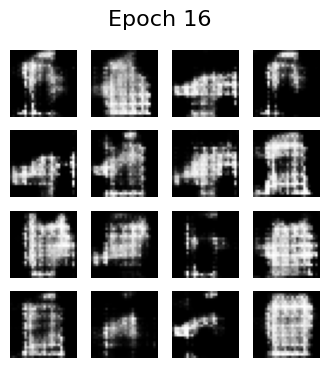

Epoch 17/50
  Epoch 17 - Batch 1: Generator loss = 1.1795, Discriminator loss = 0.9980
  Epoch 17 - Batch 2: Generator loss = 1.1158, Discriminator loss = 0.9577
  Epoch 17 - Batch 3: Generator loss = 1.0508, Discriminator loss = 0.9653
  Epoch 17 - Batch 4: Generator loss = 1.0191, Discriminator loss = 1.0171
  Epoch 17 - Batch 5: Generator loss = 1.1237, Discriminator loss = 0.9769
  Epoch 17 - Batch 6: Generator loss = 1.2433, Discriminator loss = 0.9490
  Epoch 17 - Batch 7: Generator loss = 1.2261, Discriminator loss = 0.9762
  Epoch 17 - Batch 8: Generator loss = 1.2683, Discriminator loss = 0.9310
  Epoch 17 - Batch 9: Generator loss = 1.2368, Discriminator loss = 0.9707
  Epoch 17 - Batch 10: Generator loss = 1.1872, Discriminator loss = 1.0381
  Epoch 17 - Batch 11: Generator loss = 1.0384, Discriminator loss = 1.0080
  Epoch 17 - Batch 12: Generator loss = 1.0342, Discriminator loss = 0.9777
  Epoch 17 - Batch 13: Generator loss = 1.0946, Discriminator loss = 1.0023
  Epoch 1

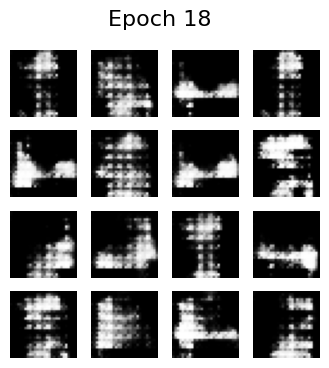

Epoch 19/50
  Epoch 19 - Batch 1: Generator loss = 1.4556, Discriminator loss = 0.8828
  Epoch 19 - Batch 2: Generator loss = 1.3233, Discriminator loss = 0.9185
  Epoch 19 - Batch 3: Generator loss = 1.3552, Discriminator loss = 0.9762
  Epoch 19 - Batch 4: Generator loss = 1.3638, Discriminator loss = 0.8688
  Epoch 19 - Batch 5: Generator loss = 1.3625, Discriminator loss = 0.9478
  Epoch 19 - Batch 6: Generator loss = 1.4208, Discriminator loss = 0.9224
  Epoch 19 - Batch 7: Generator loss = 1.4512, Discriminator loss = 1.0016
  Epoch 19 - Batch 8: Generator loss = 1.4602, Discriminator loss = 1.0139
  Epoch 19 - Batch 9: Generator loss = 1.4255, Discriminator loss = 0.9001
  Epoch 19 - Batch 10: Generator loss = 1.3394, Discriminator loss = 0.9618
  Epoch 19 - Batch 11: Generator loss = 1.3770, Discriminator loss = 0.9603
  Epoch 19 - Batch 12: Generator loss = 1.3068, Discriminator loss = 0.9572
  Epoch 19 - Batch 13: Generator loss = 1.3456, Discriminator loss = 0.9960
  Epoch 1

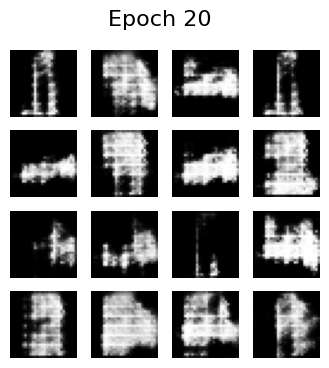

Epoch 21/50
  Epoch 21 - Batch 1: Generator loss = 1.5754, Discriminator loss = 0.8285
  Epoch 21 - Batch 2: Generator loss = 1.4978, Discriminator loss = 0.8284
  Epoch 21 - Batch 3: Generator loss = 1.4660, Discriminator loss = 0.7829
  Epoch 21 - Batch 4: Generator loss = 1.4368, Discriminator loss = 0.8203
  Epoch 21 - Batch 5: Generator loss = 1.3828, Discriminator loss = 0.8335
  Epoch 21 - Batch 6: Generator loss = 1.3382, Discriminator loss = 0.8520
  Epoch 21 - Batch 7: Generator loss = 1.3727, Discriminator loss = 0.7805
  Epoch 21 - Batch 8: Generator loss = 1.4450, Discriminator loss = 0.8409
  Epoch 21 - Batch 9: Generator loss = 1.5959, Discriminator loss = 0.8325
  Epoch 21 - Batch 10: Generator loss = 1.5996, Discriminator loss = 0.8762
  Epoch 21 - Batch 11: Generator loss = 1.5430, Discriminator loss = 0.8038
  Epoch 21 - Batch 12: Generator loss = 1.4441, Discriminator loss = 0.8180
  Epoch 21 - Batch 13: Generator loss = 1.4189, Discriminator loss = 0.8407
  Epoch 2

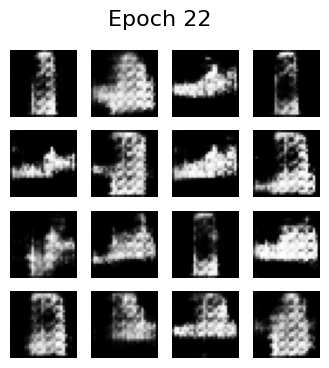

Epoch 23/50
  Epoch 23 - Batch 1: Generator loss = 1.2242, Discriminator loss = 1.0218
  Epoch 23 - Batch 2: Generator loss = 1.3684, Discriminator loss = 0.9381
  Epoch 23 - Batch 3: Generator loss = 1.4167, Discriminator loss = 1.1119
  Epoch 23 - Batch 4: Generator loss = 1.4531, Discriminator loss = 1.0469
  Epoch 23 - Batch 5: Generator loss = 1.5817, Discriminator loss = 0.9354
  Epoch 23 - Batch 6: Generator loss = 1.3928, Discriminator loss = 0.9453
  Epoch 23 - Batch 7: Generator loss = 1.3321, Discriminator loss = 0.9771
  Epoch 23 - Batch 8: Generator loss = 1.3136, Discriminator loss = 0.9786
  Epoch 23 - Batch 9: Generator loss = 1.4469, Discriminator loss = 0.9832
  Epoch 23 - Batch 10: Generator loss = 1.5231, Discriminator loss = 0.9004
  Epoch 23 - Batch 11: Generator loss = 1.4753, Discriminator loss = 0.7823
  Epoch 23 - Batch 12: Generator loss = 1.5543, Discriminator loss = 0.8446
  Epoch 23 - Batch 13: Generator loss = 1.6089, Discriminator loss = 0.8288
  Epoch 2

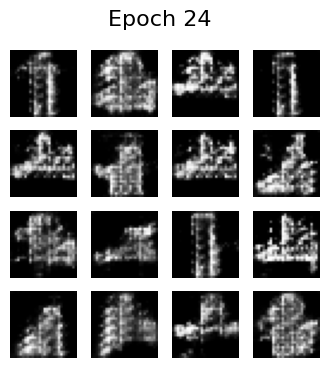

Epoch 25/50
  Epoch 25 - Batch 1: Generator loss = 2.2369, Discriminator loss = 0.5441
  Epoch 25 - Batch 2: Generator loss = 2.2101, Discriminator loss = 0.4636
  Epoch 25 - Batch 3: Generator loss = 1.9511, Discriminator loss = 0.5105
  Epoch 25 - Batch 4: Generator loss = 1.7404, Discriminator loss = 0.5515
  Epoch 25 - Batch 5: Generator loss = 1.8736, Discriminator loss = 0.4449
  Epoch 25 - Batch 6: Generator loss = 1.9618, Discriminator loss = 0.5440
  Epoch 25 - Batch 7: Generator loss = 2.0131, Discriminator loss = 0.4883
  Epoch 25 - Batch 8: Generator loss = 2.1684, Discriminator loss = 0.5013
  Epoch 25 - Batch 9: Generator loss = 2.3004, Discriminator loss = 0.5314
  Epoch 25 - Batch 10: Generator loss = 2.1373, Discriminator loss = 0.5552
  Epoch 25 - Batch 11: Generator loss = 1.9566, Discriminator loss = 0.6092
  Epoch 25 - Batch 12: Generator loss = 1.7103, Discriminator loss = 0.6204
  Epoch 25 - Batch 13: Generator loss = 1.5687, Discriminator loss = 0.5905
  Epoch 2

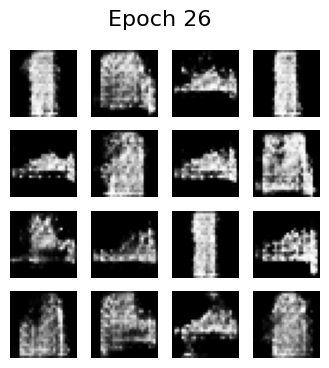

Epoch 27/50
  Epoch 27 - Batch 1: Generator loss = 2.0844, Discriminator loss = 0.5887
  Epoch 27 - Batch 2: Generator loss = 1.9003, Discriminator loss = 0.6015
  Epoch 27 - Batch 3: Generator loss = 1.8493, Discriminator loss = 0.6026
  Epoch 27 - Batch 4: Generator loss = 1.5757, Discriminator loss = 0.6489
  Epoch 27 - Batch 5: Generator loss = 1.5181, Discriminator loss = 0.6206
  Epoch 27 - Batch 6: Generator loss = 1.4994, Discriminator loss = 0.6305
  Epoch 27 - Batch 7: Generator loss = 1.7186, Discriminator loss = 0.6004
  Epoch 27 - Batch 8: Generator loss = 1.8216, Discriminator loss = 0.5557
  Epoch 27 - Batch 9: Generator loss = 2.0204, Discriminator loss = 0.6369
  Epoch 27 - Batch 10: Generator loss = 1.9208, Discriminator loss = 0.6656
  Epoch 27 - Batch 11: Generator loss = 1.7188, Discriminator loss = 0.6445
  Epoch 27 - Batch 12: Generator loss = 1.5769, Discriminator loss = 0.6165
  Epoch 27 - Batch 13: Generator loss = 1.4791, Discriminator loss = 0.6656
  Epoch 2

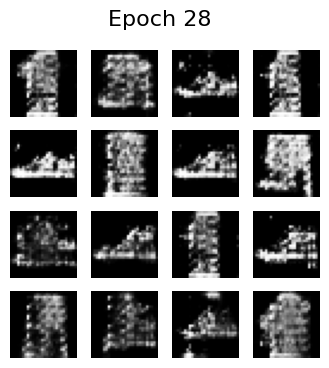

Epoch 29/50
  Epoch 29 - Batch 1: Generator loss = 1.6551, Discriminator loss = 0.7348
  Epoch 29 - Batch 2: Generator loss = 1.6603, Discriminator loss = 0.7206
  Epoch 29 - Batch 3: Generator loss = 1.5965, Discriminator loss = 0.7777
  Epoch 29 - Batch 4: Generator loss = 1.6554, Discriminator loss = 0.8198
  Epoch 29 - Batch 5: Generator loss = 1.6484, Discriminator loss = 0.7876
  Epoch 29 - Batch 6: Generator loss = 1.6618, Discriminator loss = 0.7536
  Epoch 29 - Batch 7: Generator loss = 1.7171, Discriminator loss = 0.7336
  Epoch 29 - Batch 8: Generator loss = 1.6815, Discriminator loss = 0.8405
  Epoch 29 - Batch 9: Generator loss = 1.7327, Discriminator loss = 0.6296
  Epoch 29 - Batch 10: Generator loss = 1.8248, Discriminator loss = 0.7220
  Epoch 29 - Batch 11: Generator loss = 1.8419, Discriminator loss = 0.7973
  Epoch 29 - Batch 12: Generator loss = 1.6959, Discriminator loss = 0.7927
  Epoch 29 - Batch 13: Generator loss = 1.6621, Discriminator loss = 0.7306
  Epoch 2

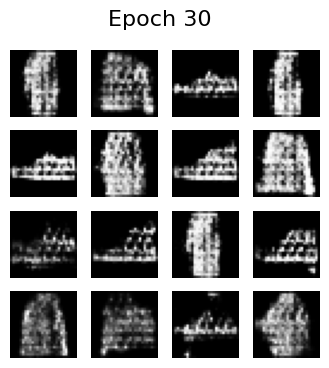

Epoch 31/50
  Epoch 31 - Batch 1: Generator loss = 1.9548, Discriminator loss = 0.7992
  Epoch 31 - Batch 2: Generator loss = 2.1674, Discriminator loss = 0.6244
  Epoch 31 - Batch 3: Generator loss = 2.0211, Discriminator loss = 0.7013
  Epoch 31 - Batch 4: Generator loss = 1.9218, Discriminator loss = 0.6824
  Epoch 31 - Batch 5: Generator loss = 1.7027, Discriminator loss = 0.7007
  Epoch 31 - Batch 6: Generator loss = 1.6363, Discriminator loss = 0.6483
  Epoch 31 - Batch 7: Generator loss = 1.5193, Discriminator loss = 0.6656
  Epoch 31 - Batch 8: Generator loss = 1.6371, Discriminator loss = 0.7591
  Epoch 31 - Batch 9: Generator loss = 1.8497, Discriminator loss = 0.7345
  Epoch 31 - Batch 10: Generator loss = 1.8786, Discriminator loss = 0.7100
  Epoch 31 - Batch 11: Generator loss = 2.1103, Discriminator loss = 0.7849
  Epoch 31 - Batch 12: Generator loss = 2.0196, Discriminator loss = 0.7700
  Epoch 31 - Batch 13: Generator loss = 1.7448, Discriminator loss = 0.7586
  Epoch 3

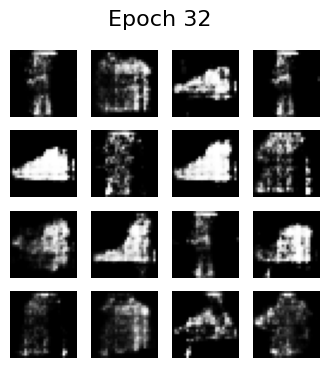

Epoch 33/50
  Epoch 33 - Batch 1: Generator loss = 2.4041, Discriminator loss = 0.3648
  Epoch 33 - Batch 2: Generator loss = 2.3329, Discriminator loss = 0.4101
  Epoch 33 - Batch 3: Generator loss = 2.4337, Discriminator loss = 0.3513
  Epoch 33 - Batch 4: Generator loss = 2.3444, Discriminator loss = 0.3689
  Epoch 33 - Batch 5: Generator loss = 2.4601, Discriminator loss = 0.3070
  Epoch 33 - Batch 6: Generator loss = 2.6447, Discriminator loss = 0.3258
  Epoch 33 - Batch 7: Generator loss = 2.7739, Discriminator loss = 0.3169
  Epoch 33 - Batch 8: Generator loss = 2.7106, Discriminator loss = 0.4505
  Epoch 33 - Batch 9: Generator loss = 2.6025, Discriminator loss = 0.3644
  Epoch 33 - Batch 10: Generator loss = 2.4452, Discriminator loss = 0.4017
  Epoch 33 - Batch 11: Generator loss = 2.4013, Discriminator loss = 0.3443
  Epoch 33 - Batch 12: Generator loss = 2.2279, Discriminator loss = 0.4171
  Epoch 33 - Batch 13: Generator loss = 2.3896, Discriminator loss = 0.4226
  Epoch 3

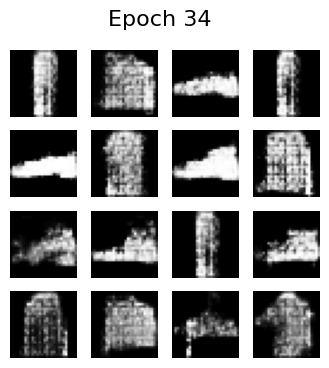

Epoch 35/50
  Epoch 35 - Batch 1: Generator loss = 1.6326, Discriminator loss = 0.9185
  Epoch 35 - Batch 2: Generator loss = 1.5936, Discriminator loss = 0.8685
  Epoch 35 - Batch 3: Generator loss = 1.7391, Discriminator loss = 0.9131
  Epoch 35 - Batch 4: Generator loss = 1.6575, Discriminator loss = 0.9275
  Epoch 35 - Batch 5: Generator loss = 1.6348, Discriminator loss = 0.9138
  Epoch 35 - Batch 6: Generator loss = 1.4733, Discriminator loss = 0.9159
  Epoch 35 - Batch 7: Generator loss = 1.6202, Discriminator loss = 0.8275
  Epoch 35 - Batch 8: Generator loss = 1.6736, Discriminator loss = 0.9145
  Epoch 35 - Batch 9: Generator loss = 1.7162, Discriminator loss = 0.9230
  Epoch 35 - Batch 10: Generator loss = 1.7020, Discriminator loss = 0.9095
  Epoch 35 - Batch 11: Generator loss = 1.6015, Discriminator loss = 0.8586
  Epoch 35 - Batch 12: Generator loss = 1.4804, Discriminator loss = 0.8646
  Epoch 35 - Batch 13: Generator loss = 1.4599, Discriminator loss = 0.8233
  Epoch 3

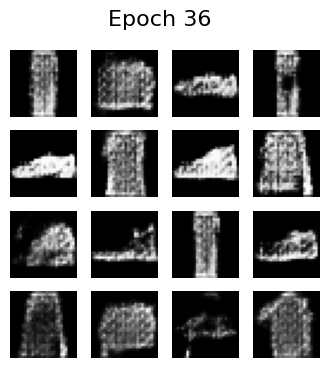

Epoch 37/50
  Epoch 37 - Batch 1: Generator loss = 1.5484, Discriminator loss = 1.0036
  Epoch 37 - Batch 2: Generator loss = 1.3555, Discriminator loss = 0.9303
  Epoch 37 - Batch 3: Generator loss = 1.4735, Discriminator loss = 0.9339
  Epoch 37 - Batch 4: Generator loss = 1.7654, Discriminator loss = 0.8711
  Epoch 37 - Batch 5: Generator loss = 1.9630, Discriminator loss = 1.0306
  Epoch 37 - Batch 6: Generator loss = 1.7927, Discriminator loss = 0.9402
  Epoch 37 - Batch 7: Generator loss = 1.5006, Discriminator loss = 0.9637
  Epoch 37 - Batch 8: Generator loss = 1.3613, Discriminator loss = 0.9409
  Epoch 37 - Batch 9: Generator loss = 1.5430, Discriminator loss = 0.8695
  Epoch 37 - Batch 10: Generator loss = 1.7273, Discriminator loss = 0.8934
  Epoch 37 - Batch 11: Generator loss = 1.8318, Discriminator loss = 0.9418
  Epoch 37 - Batch 12: Generator loss = 1.9540, Discriminator loss = 0.8799
  Epoch 37 - Batch 13: Generator loss = 1.7792, Discriminator loss = 0.7848
  Epoch 3

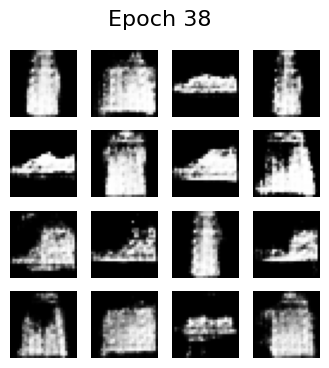

Epoch 39/50
  Epoch 39 - Batch 1: Generator loss = 1.9673, Discriminator loss = 0.7154
  Epoch 39 - Batch 2: Generator loss = 1.9035, Discriminator loss = 0.6927
  Epoch 39 - Batch 3: Generator loss = 1.8239, Discriminator loss = 0.6193
  Epoch 39 - Batch 4: Generator loss = 1.8211, Discriminator loss = 0.6276
  Epoch 39 - Batch 5: Generator loss = 1.9793, Discriminator loss = 0.6513
  Epoch 39 - Batch 6: Generator loss = 1.9378, Discriminator loss = 0.7005
  Epoch 39 - Batch 7: Generator loss = 2.0530, Discriminator loss = 0.7120
  Epoch 39 - Batch 8: Generator loss = 2.0843, Discriminator loss = 0.6679
  Epoch 39 - Batch 9: Generator loss = 1.8777, Discriminator loss = 0.7397
  Epoch 39 - Batch 10: Generator loss = 1.8746, Discriminator loss = 0.6866
  Epoch 39 - Batch 11: Generator loss = 1.7260, Discriminator loss = 0.7873
  Epoch 39 - Batch 12: Generator loss = 1.7653, Discriminator loss = 0.6321
  Epoch 39 - Batch 13: Generator loss = 1.8131, Discriminator loss = 0.7374
  Epoch 3

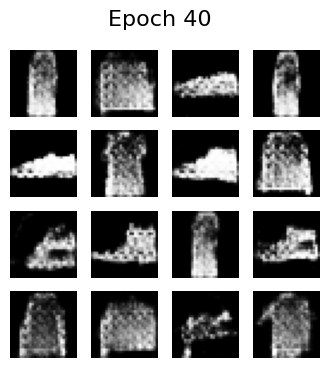

Epoch 41/50
  Epoch 41 - Batch 1: Generator loss = 1.8302, Discriminator loss = 0.6356
  Epoch 41 - Batch 2: Generator loss = 1.8384, Discriminator loss = 0.6143
  Epoch 41 - Batch 3: Generator loss = 1.7751, Discriminator loss = 0.6751
  Epoch 41 - Batch 4: Generator loss = 1.7420, Discriminator loss = 0.7554
  Epoch 41 - Batch 5: Generator loss = 1.5910, Discriminator loss = 0.6815
  Epoch 41 - Batch 6: Generator loss = 1.5302, Discriminator loss = 0.7655
  Epoch 41 - Batch 7: Generator loss = 1.5931, Discriminator loss = 0.7464
  Epoch 41 - Batch 8: Generator loss = 1.8915, Discriminator loss = 0.6787
  Epoch 41 - Batch 9: Generator loss = 1.9714, Discriminator loss = 0.7248
  Epoch 41 - Batch 10: Generator loss = 1.9455, Discriminator loss = 0.7588
  Epoch 41 - Batch 11: Generator loss = 1.5983, Discriminator loss = 0.7844
  Epoch 41 - Batch 12: Generator loss = 1.5968, Discriminator loss = 0.7095
  Epoch 41 - Batch 13: Generator loss = 1.4690, Discriminator loss = 0.7396
  Epoch 4

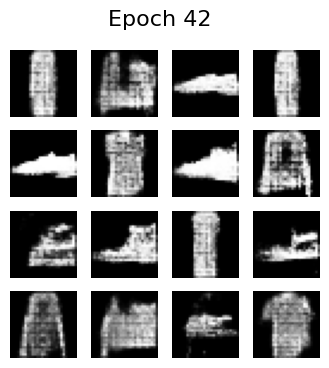

Epoch 43/50
  Epoch 43 - Batch 1: Generator loss = 1.5194, Discriminator loss = 0.9050
  Epoch 43 - Batch 2: Generator loss = 1.6502, Discriminator loss = 0.8908
  Epoch 43 - Batch 3: Generator loss = 1.5186, Discriminator loss = 0.9334
  Epoch 43 - Batch 4: Generator loss = 1.4561, Discriminator loss = 0.9599
  Epoch 43 - Batch 5: Generator loss = 1.4319, Discriminator loss = 0.8267
  Epoch 43 - Batch 6: Generator loss = 1.5132, Discriminator loss = 0.8434
  Epoch 43 - Batch 7: Generator loss = 1.6856, Discriminator loss = 0.7922
  Epoch 43 - Batch 8: Generator loss = 1.8385, Discriminator loss = 0.9546
  Epoch 43 - Batch 9: Generator loss = 1.6618, Discriminator loss = 0.8911
  Epoch 43 - Batch 10: Generator loss = 1.7065, Discriminator loss = 0.8506
  Epoch 43 - Batch 11: Generator loss = 1.4898, Discriminator loss = 0.8840
  Epoch 43 - Batch 12: Generator loss = 1.4504, Discriminator loss = 0.8675
  Epoch 43 - Batch 13: Generator loss = 1.4803, Discriminator loss = 0.7659
  Epoch 4

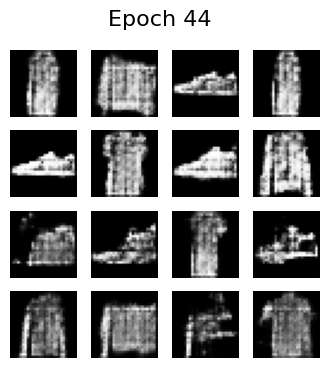

Epoch 45/50
  Epoch 45 - Batch 1: Generator loss = 1.5708, Discriminator loss = 1.1253
  Epoch 45 - Batch 2: Generator loss = 1.4308, Discriminator loss = 1.1301
  Epoch 45 - Batch 3: Generator loss = 1.3298, Discriminator loss = 1.1472
  Epoch 45 - Batch 4: Generator loss = 1.3289, Discriminator loss = 1.1462
  Epoch 45 - Batch 5: Generator loss = 1.3183, Discriminator loss = 1.1422
  Epoch 45 - Batch 6: Generator loss = 1.4594, Discriminator loss = 1.1105
  Epoch 45 - Batch 7: Generator loss = 1.4408, Discriminator loss = 1.1227
  Epoch 45 - Batch 8: Generator loss = 1.5284, Discriminator loss = 1.0161
  Epoch 45 - Batch 9: Generator loss = 1.4592, Discriminator loss = 1.0742
  Epoch 45 - Batch 10: Generator loss = 1.5366, Discriminator loss = 1.0701
  Epoch 45 - Batch 11: Generator loss = 1.4139, Discriminator loss = 1.0824
  Epoch 45 - Batch 12: Generator loss = 1.4354, Discriminator loss = 0.9903
  Epoch 45 - Batch 13: Generator loss = 1.3937, Discriminator loss = 1.0421
  Epoch 4

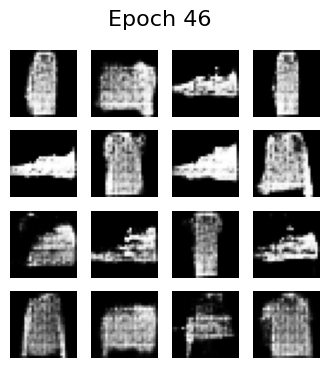

Epoch 47/50
  Epoch 47 - Batch 1: Generator loss = 1.4751, Discriminator loss = 0.9146
  Epoch 47 - Batch 2: Generator loss = 1.4301, Discriminator loss = 0.9703
  Epoch 47 - Batch 3: Generator loss = 1.4361, Discriminator loss = 0.8614
  Epoch 47 - Batch 4: Generator loss = 1.5793, Discriminator loss = 0.8335
  Epoch 47 - Batch 5: Generator loss = 1.6602, Discriminator loss = 0.9072
  Epoch 47 - Batch 6: Generator loss = 1.9110, Discriminator loss = 0.8552
  Epoch 47 - Batch 7: Generator loss = 1.8079, Discriminator loss = 0.9200
  Epoch 47 - Batch 8: Generator loss = 1.8285, Discriminator loss = 0.7629
  Epoch 47 - Batch 9: Generator loss = 1.5419, Discriminator loss = 0.8903
  Epoch 47 - Batch 10: Generator loss = 1.4796, Discriminator loss = 0.8833
  Epoch 47 - Batch 11: Generator loss = 1.4981, Discriminator loss = 0.8719
  Epoch 47 - Batch 12: Generator loss = 1.4185, Discriminator loss = 0.9060
  Epoch 47 - Batch 13: Generator loss = 1.5670, Discriminator loss = 0.8193
  Epoch 4

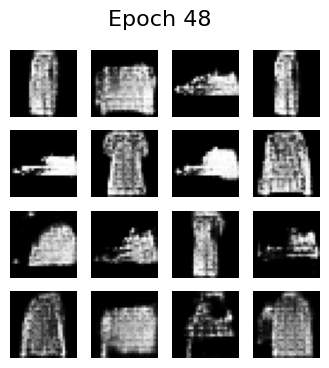

Epoch 49/50
  Epoch 49 - Batch 1: Generator loss = 1.5386, Discriminator loss = 0.8339
  Epoch 49 - Batch 2: Generator loss = 1.5121, Discriminator loss = 0.8732
  Epoch 49 - Batch 3: Generator loss = 1.4269, Discriminator loss = 0.8706
  Epoch 49 - Batch 4: Generator loss = 1.5803, Discriminator loss = 0.8076
  Epoch 49 - Batch 5: Generator loss = 1.5867, Discriminator loss = 0.8698
  Epoch 49 - Batch 6: Generator loss = 1.6881, Discriminator loss = 0.8379
  Epoch 49 - Batch 7: Generator loss = 1.6224, Discriminator loss = 0.7763
  Epoch 49 - Batch 8: Generator loss = 1.6233, Discriminator loss = 0.8803
  Epoch 49 - Batch 9: Generator loss = 1.6389, Discriminator loss = 0.8626
  Epoch 49 - Batch 10: Generator loss = 1.5736, Discriminator loss = 0.8737
  Epoch 49 - Batch 11: Generator loss = 1.4935, Discriminator loss = 0.8337
  Epoch 49 - Batch 12: Generator loss = 1.5174, Discriminator loss = 0.7549
  Epoch 49 - Batch 13: Generator loss = 1.5289, Discriminator loss = 0.8082
  Epoch 4

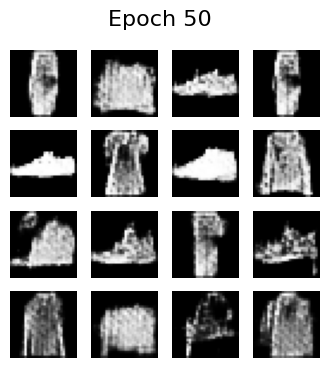

In [9]:
# Entrenar la GAN
train(train_dataset, EPOCHS)

## Guardar los modelos

In [10]:
# Crear carpeta para guardar modelos si no existe
if not os.path.exists('models'):
    os.makedirs('models')

# Guardar el generador y el discriminador
generator.save('models/generator.h5')
discriminator.save('models/discriminator.h5')
print("Modelos guardados en la carpeta 'models'.")

Modelos guardados en la carpeta 'models'.


## Generar una muestra

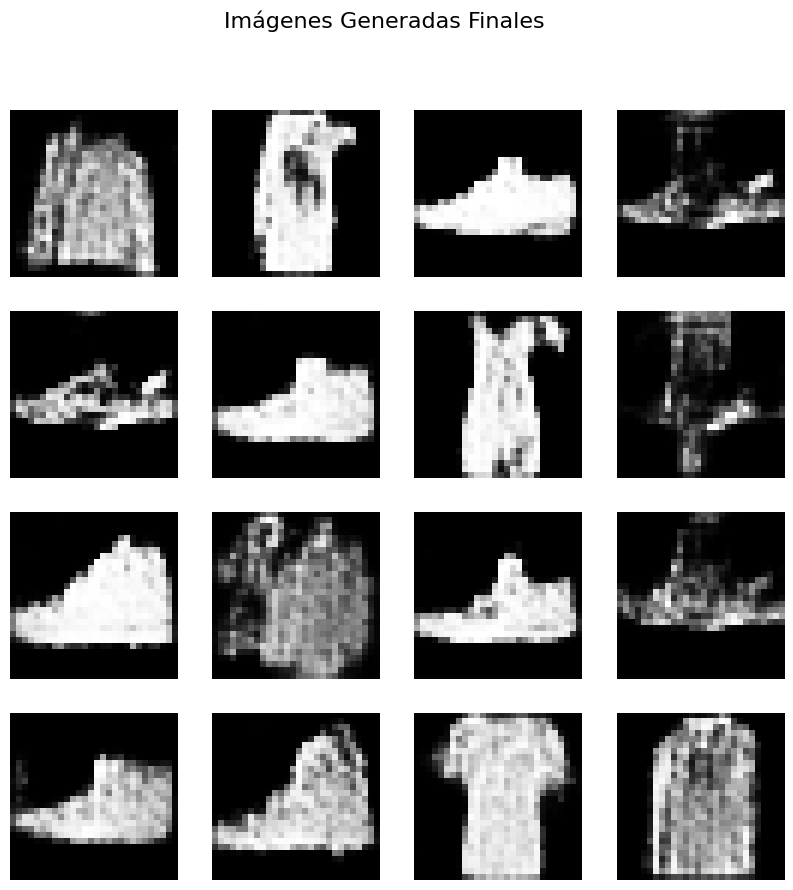

In [11]:
# Generar un conjunto de imágenes finales utilizando la semilla fija
noise = tf.random.normal([num_examples_to_generate, noise_dim])
generated_images = generator(noise, training=False)

plt.figure(figsize=(10,10))
for i in range(num_examples_to_generate):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.suptitle("Imágenes Generadas Finales", fontsize=16)
plt.show()

# Conclusiones:

Se implementó una GAN para generar imágenes del dataset Fashion MNIST.

- **Generador:** transforma un vector de ruido en una imagen de 28x28x1 utilizando capas Dense y Conv2DTranspose.

- **Discriminador:** clasifica imágenes reales y generadas utilizando capas Conv2D.

- Se definieron funciones de pérdida y optimizadores para entrenar ambos modelos en conjunto.

- Se muestra el progreso del entrenamiento mediante la visualización de imágenes generadas en cada epoch.